<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from google.colab import drive
from keras import backend as K
from PIL import Image

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [ ]:
df[df['dataset']=='refuge'].groupby(['tag']).size()

# Misc

In [ ]:
H_OD = np.array([])
H_OC = np.array([])
W_OD = np.array([])
W_OC = np.array([])
for i in range(len(df)):
  OD_mask = cv2.imread(df['path_OD_png'][i], 0)
  OC_mask = cv2.imread(df['path_OC_png'][i], 0)
  OD_mask,_ = cv2.findContours(OD_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OC_mask,_ = cv2.findContours(OC_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OD_mask = cv2.approxPolyDP(OD_mask[0], 3, True)
  OC_mask = cv2.approxPolyDP(OC_mask[0], 3, True)
  _, _, w_OD, h_OD = cv2.boundingRect(OD_mask)
  _, _, w_OC, h_OC = cv2.boundingRect(OC_mask)
  H_OD = np.append(H_OD, h_OD)
  H_OC = np.append(H_OC, h_OC)
  W_OD = np.append(W_OD, w_OD)
  W_OC = np.append(W_OC, w_OC)

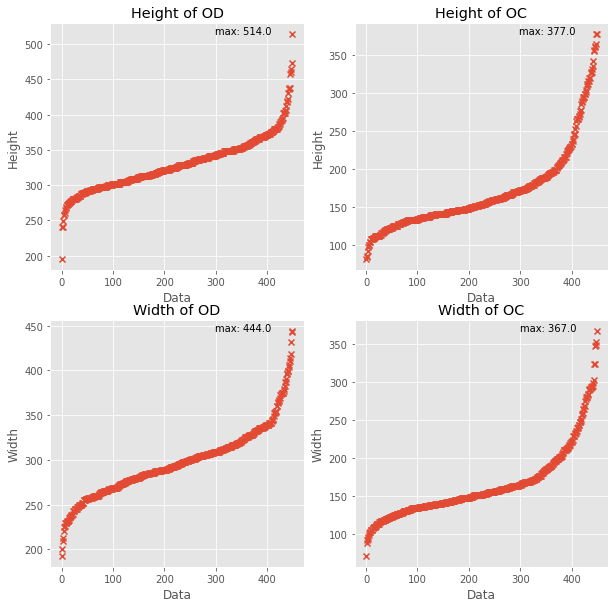

In [ ]:
H_OD = np.sort(H_OD, axis=0)
H_OC = np.sort(H_OC, axis=0)
W_OD = np.sort(W_OD, axis=0)
W_OC = np.sort(W_OC, axis=0)
plt.figure(figsize=(10,10))
plt.subplot(221), 
plt.scatter(list(range(len(df))), H_OD, marker='x')
plt.title('Height of OD')
plt.text(np.argmax(H_OD)-150, np.max(H_OD), 'max: {}'.format(np.max(H_OD)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(222),
plt.scatter(list(range(len(df))), H_OC, marker='x')
plt.title('Height of OC')
plt.text(np.argmax(H_OC)-150, np.max(H_OC), 'max: {}'.format(np.max(H_OC)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(223),
plt.scatter(list(range(len(df))), W_OD, marker='x')
plt.title('Width of OD')
plt.text(np.argmax(W_OD)-150, np.max(W_OD), 'max: {}'.format(np.max(W_OD)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.subplot(224),
plt.scatter(list(range(len(df))), W_OC, marker='x')
plt.title('Width of OC')
plt.text(np.argmax(W_OC)-150, np.max(W_OC), 'max: {}'.format(np.max(W_OC)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.show()

In [ ]:
error_OD = []
error_OC = []
for i in range(len(df)):
  img_OD = cv2.imread(df['path_OD_png'][5], 0)
  img_OD,_ = ekstrakROI(df['disc_center'][5], 550, img_OD)
  img1_OD = img_OD/255.0
  img2_OD = resize(img1_OD, (256, 256), mode = 'constant', preserve_range = True)
  img3_OD = cv2.resize(img2_OD, (550, 550), interpolation = cv2.INTER_CUBIC)
  #img3 = resize(img2, (550, 550), mode='constant', preserve_range=True)
  img3_OD = img3_OD>0.5

  img_OC = cv2.imread(df['path_OC_png'][5], 0)
  img_OC,_ = ekstrakROI(df['disc_center'][5], 550, img_OC)
  img1_OC = img_OC/255.0
  img2_OC = resize(img1_OC, (256, 256), mode = 'constant', preserve_range = True)
  img3_OC = cv2.resize(img2_OC, (550, 550), interpolation = cv2.INTER_CUBIC)
  #img3 = resize(img2, (550, 550), mode='constant', preserve_range=True)
  img3_OC = img3_OC>0.5

  DSC_OD = np.sum(img3_OD[img1_OD==1.0])*2.0 / (np.sum(img3_OD) + np.sum(img1_OD))
  DSC_OC = np.sum(img3_OC[img1_OC==1.0])*2.0 / (np.sum(img3_OC) + np.sum(img1_OC))

  error_OD.append(1-DSC_OD)
  error_OC.append(1-DSC_OC)

error_OD = np.array(error_OD)
error_OC = np.array(error_OC)
print('Mean error dari resizing OD: {:.6f}'.format(np.mean(error_OD)))
print('STD error dari resizing OD: {:.6f}'.format(np.std(error_OD)))
print('Mean error dari resizing OC: {:.6f}'.format(np.mean(error_OC)))
print('STD error dari resizing OC: {:.6f}'.format(np.std(error_OC)))

# Functions

In [4]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)
  dx = (x1 - x0) - s
  dy = (y1 - y0) - s
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    x0 += dx
  else:
    x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    y0 += dy
  else:
    y0 += dy

  return y0, y1, x0, x1

In [5]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image

def ekstrakROI(centroid, s, img):
  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def histo(histories):
  for i, histori in enumerate(histories):
    plt.figure(figsize=(20, 5))
    print('Fold-{}'.format(i+1))
    plt.subplot(131), 
    plt.plot(histori.history["accuracy"], label="accuracy")
    plt.plot(histori.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmax(histori.history["val_accuracy"]), np.max(histori.history["val_accuracy"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(132), 
    plt.plot(histori.history["fscore"], label="fscore")
    plt.plot(histori.history["val_fscore"], label="val_fscore")
    plt.plot( np.argmax(histori.history["val_fscore"]), np.max(histori.history["val_fscore"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Fscore")
    plt.legend()
    plt.subplot(133),
    plt.plot(histori.history["loss"], label="loss")
    plt.plot(histori.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(histori.history["val_loss"]), np.min(histori.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.show()

In [8]:
def downscale(img):
  size = (256, 256)
  img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
  return img

def upscale(img):
  size = (550, 550)
  img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
  return img

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    li = Lambda(downscale, name="lambda_input")(input_img)
    c1 = conv2d_block(li, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    lo = Lambda(upscale, name="lambda_output")(outputs)
    
    
    model = Model(inputs=[input_img], outputs=[lo])
    return model

In [10]:
def index_shuffle(ix, k=5, random_state=4):
  ix_dr_gl = np.array(ix[0])
  ix_dr_n = np.array(ix[1])
  ix_re_gl = np.array(ix[2])
  ix_re_n = np.array(ix[3])

  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)

  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  ix_dataset = []
  for i in range(k):
    # meta-index for train data
    tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
    tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
    tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
    tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

    # meta-index for test data
    te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
    te_dr_n = list(range(dr_n[i], dr_n[i+1]))
    te_re_gl = list(range(re_gl[i], re_gl[i+1]))
    te_re_n = list(range(re_n[i], re_n[i+1]))

    ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n], ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
    ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n], ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))

    random.Random(random_state).shuffle(ix_train)
    random.Random(random_state).shuffle(ix_test)

    ix_dataset.append([ix_train, ix_test])
  
  return ix_dataset

In [11]:
def k_fold_cross_data(X, y, k=5, test_size=0.2, random_state=4):
  X_dr_gl = np.array(X[0])
  X_dr_n = np.array(X[1])
  X_re_gl = np.array(X[2])
  X_re_n = np.array(X[3])
  y_dr_gl = np.array(y[0])
  y_dr_n = np.array(y[1])
  y_re_gl = np.array(y[2])
  y_re_n = np.array(y[3])
  random.Random(random_state).shuffle(X_dr_gl)
  random.Random(random_state).shuffle(X_dr_n)
  random.Random(random_state).shuffle(X_re_gl)
  random.Random(random_state).shuffle(X_re_n)
  random.Random(random_state).shuffle(y_dr_gl)
  random.Random(random_state).shuffle(y_dr_n)
  random.Random(random_state).shuffle(y_re_gl)
  random.Random(random_state).shuffle(y_re_n)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  dataset = []
  for i in tqdm_notebook(range(k)):
    # index of dataset-label for train data
    tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
    tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
    tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
    tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

    # index of dataset-label for test data
    te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
    te_dr_n = list(range(dr_n[i], dr_n[i+1]))
    te_re_gl = list(range(re_gl[i], re_gl[i+1]))
    te_re_n = list(range(re_n[i], re_n[i+1]))

    X_train = np.concatenate((X_dr_gl[tr_dr_gl], X_dr_n[tr_dr_n], 
                             X_re_gl[tr_re_gl], X_re_n[tr_re_n]))
    X_test = np.concatenate((X_dr_gl[te_dr_gl], X_dr_n[te_dr_n], 
                             X_re_gl[te_re_gl], X_re_n[te_re_n]))
    y_train = np.concatenate((y_dr_gl[tr_dr_gl], y_dr_n[tr_dr_n], 
                             y_re_gl[tr_re_gl], y_re_n[tr_re_n]))
    y_test = np.concatenate((y_dr_gl[te_dr_gl], y_dr_n[te_dr_n], 
                             y_re_gl[te_re_gl], y_re_n[te_re_n]))
    
    random.Random(random_state).shuffle(X_train)
    random.Random(random_state).shuffle(X_test)
    random.Random(random_state).shuffle(y_train)
    random.Random(random_state).shuffle(y_test)
    dataset.append([X_train, X_test, y_train, y_test])
  
  return dataset

In [12]:
def gray2rgb(gray_image):
  h, w = gray_image.shape[:2]
  gray_image = gray_image.squeeze()
  rgb_image = np.zeros((h, w, 3), np.uint8)
  rgb_image[:, :, 0] = gray_image
  rgb_image[:, :, 1] = gray_image
  rgb_image[:, :, 2] = gray_image
  return rgb_image

In [54]:
def show_examples(examples, y_examples):
  plt.figure(figsize=(12, 4))
  for i, example in enumerate(examples):
    h, w = example.shape[:2]
    mask = np.array(example > 0.5, np.uint8)*255
    gt_mask = np.array(y_examples[i] > 0, np.uint8)*255
    DSC = np.sum(mask[gt_mask==255])*2.0 / (np.sum(mask) + np.sum(gt_mask))
    mask = mask.squeeze()
    gt_mask = gt_mask.squeeze()
    mask_show = np.zeros((h, w, 3), np.uint8)
    gt_mask_show = np.zeros((h, w, 3), np.uint8)

    mask_show[:, :, 0] = mask
    gt_mask_show[:, :, 2] = gt_mask
    
    plt.subplot(1, len(examples), i+1),
    plt.imshow(mask_show,  interpolation='none')
    plt.imshow(gt_mask_show, interpolation='none', alpha=0.35)
    plt.text(20, 20, 'DSC: {:.3f}'.format(DSC), fontsize='small', color ='w')

  plt.show()

In [55]:
def k_fold_crossval(X, y, ix, callbacks, tipe, k=5, test_size=0.2, random_state=4,
                    verbose=0, save=0):
  ix_dataset = index_shuffle(ix, k=k, random_state=random_state)
  input_img = Input((550, 550, 1), name='img')
  results = []
  fold = []
  Loss = []
  Accuracy = []
  f1score = []
  models= []
  for i in tqdm_notebook(range(k)):
    # index of dataset-label for train data

    ix_train, ix_test = ix_dataset[i]

    print('Evaluate fold ', i+1)
    model= get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",fscore])
    result = model.fit(X[ix_train], y[ix_train], batch_size=32, epochs=100, callbacks=callbacks,\
                    validation_data=(X[ix_test], y[ix_test]), verbose=verbose)
    results.append(result)
    los = result.history['val_loss'][-1]
    acc = result.history['val_accuracy'][-1]
    f1 = result.history['val_fscore'][-1]

    ix_example = list(range(len(ix_test)))
    random.Random(random_state).shuffle(ix_example)
    ix_example = ix_example[:3]
    y_examples = y[ix_test][ix_example]
    examples = model.predict(X[ix_test][ix_example])                                                    

    fold.append(i + 1)
    Loss.append(los)
    Accuracy.append(acc)
    f1score.append(f1)
    models.append(model)
    print('Fold {}: loss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(i+1, los, acc, f1))
    show_examples(examples, y_examples)

  metrics = pd.DataFrame({'Fold': fold, 'Loss':Loss, 'Acc':Accuracy,
                          'Fscore': f1score})
  

  best_fold = np.argmax(f1score)
  print('Best model is fold-', best_fold+1)
  if save:
    print('Saving best model from fold-', best_fold+1)
    models[best_fold].save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model {} semantic/'.format(tipe))
    print('Save model success!')
  return results, metrics

In [15]:
def saving_image(img, path):
  if os.path.isfile(path):
    os.remove(path)
    cv2.imwrite(path, img)
  else:
    cv2.imwrite(path, img)

# Acquiring data

In [ ]:
path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Data semantic/"

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)/255.0
  gt_OD = cv2.imread(df['path_OD_png'][i], 0)/255.0
  gt_OC = cv2.imread(df['path_OC_png'][i], 0)/255.0

  img,_ = ekstrakROI(center, 550, img)
  gt_OD,_ = ekstrakROI(center, 550, gt_OD)
  gt_OC,_ = ekstrakROI(center, 550, gt_OC)


  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      saving_image(img, path+'drishti/glaucoma/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'drishti/glaucoma/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'drishti/glaucoma/gt/gtOC_{}.png'.format(i+1))
    elif df['tag'][i] == 'Normal':
      saving_image(img, path+'drishti/normal/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'drishti/normal/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'drishti/normal/gt/gtOC_{}.png'.format(i+1))
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      saving_image(img, path+'refuge/glaucoma/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'refuge/glaucoma/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'refuge/glaucoma/gt/gtOC_{}.png'.format(i+1))
    elif df['tag'][i] == 'Normal':
      saving_image(img, path+'refuge/normal/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'refuge/normal/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'refuge/normal/gt/gtOC_{}.png'.format(i+1))
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Simple data aquirement
path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Data semantic/"
X = []
y_OD = []
y_OC = []
ix_dr_gl = []
ix_dr_n = []
ix_re_gl = []
ix_re_n = []
for i in tqdm_notebook(range(0, len(df))):  
  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      img = cv2.imread(path+'drishti/glaucoma/image/image_{}.png'.format(i+1), 0)
      gt_OD = cv2.imread(path+'drishti/glaucoma/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC = cv2.imread(path+'drishti/glaucoma/gt/gtOC_{}.png'.format(i+1), 0)
      X.append(img)
      y_OD.append(gt_OD)
      y_OC.append(gt_OC)
      ix_dr_gl.append(i)

    elif df['tag'][i] == 'Normal':
      img = cv2.imread(path+'drishti/normal/image/image_{}.png'.format(i+1), 0)   
      gt_OD = cv2.imread(path+'drishti/normal/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC = cv2.imread(path+'drishti/normal/gt/gtOC_{}.png'.format(i+1), 0)
      X.append(img)
      y_OD.append(gt_OD)
      y_OC.append(gt_OC)
      ix_dr_n.append(i)

  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      img = cv2.imread(path+'refuge/glaucoma/image/image_{}.png'.format(i+1), 0)   
      gt_OD  = cv2.imread(path+'refuge/glaucoma/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC  = cv2.imread(path+'refuge/glaucoma/gt/gtOC_{}.png'.format(i+1), 0)
      X.append(img)
      y_OD.append(gt_OD)
      y_OC.append(gt_OC)
      ix_re_gl.append(i)
    elif df['tag'][i] == 'Normal':
      img = cv2.imread(path+'refuge/normal/image/image_{}.png'.format(i+1), 0)   
      gt_OD  = cv2.imread(path+'refuge/normal/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC  = cv2.imread(path+'refuge/normal/gt/gtOC_{}.png'.format(i+1), 0)
      X.append(img)
      y_OD.append(gt_OD)
      y_OC.append(gt_OC)
      ix_re_n.append(i)

ix = [ix_dr_gl, ix_dr_n, ix_re_gl, ix_re_n]
X = np.array(X)
y_OD = np.array(y_OD)
y_OC = np.array(y_OC)
X = np.expand_dims(X, axis=3)
y_OD = np.expand_dims(y_OD, axis=3)
y_OC = np.expand_dims(y_OC, axis=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Data Acquirement for 5 fold cross validation

X_dr_gl = []
X_dr_n = []
X_re_gl = []
X_re_n = []
y_dr_gl_OD = []
y_dr_n_OD = []
y_re_gl_OD = []
y_re_n_OD = []
y_dr_gl_OC = []
y_dr_n_OC = []
y_re_gl_OC = []
y_re_n_OC = []
for i in tqdm_notebook(range(0, len(df))):  
  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      img = cv2.imread(path+'drishti/glaucoma/image/image_{}.png'.format(i+1), 0)
      gt_OD = cv2.imread(path+'drishti/glaucoma/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC = cv2.imread(path+'drishti/glaucoma/gt/gtOC_{}.png'.format(i+1), 0)
      X_dr_gl.append(img)
      y_dr_gl_OD.append(gt_OD)
      y_dr_gl_OC.append(gt_OC)

    elif df['tag'][i] == 'Normal':
      img = cv2.imread(path+'drishti/normal/image/image_{}.png'.format(i+1), 0)   
      gt_OD = cv2.imread(path+'drishti/normal/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC = cv2.imread(path+'drishti/normal/gt/gtOC_{}.png'.format(i+1), 0)
      X_dr_n.append(img)
      y_dr_n_OD.append(gt_OD)
      y_dr_n_OC.append(gt_OC)
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      img = cv2.imread(path+'refuge/glaucoma/image/image_{}.png'.format(i+1), 0)   
      gt_OD  = cv2.imread(path+'refuge/glaucoma/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC  = cv2.imread(path+'refuge/glaucoma/gt/gtOC_{}.png'.format(i+1), 0)
      X_re_gl.append(img)
      y_re_gl_OD.append(gt_OD)
      y_re_gl_OC.append(gt_OC)
    elif df['tag'][i] == 'Normal':
      img = cv2.imread(path+'refuge/normal/image/image_{}.png'.format(i+1), 0)   
      gt_OD  = cv2.imread(path+'refuge/normal/gt/gtOD_{}.png'.format(i+1), 0)
      gt_OC  = cv2.imread(path+'refuge/normal/gt/gtOC_{}.png'.format(i+1), 0)
      X_re_n.append(img/255.0)
      y_re_n_OD.append(gt_OD/255.0)
      y_re_n_OC.append(gt_OC/255.0)

X = [X_dr_gl, X_dr_n, X_re_gl, X_re_n]
y_OD = [y_dr_gl_OD, y_dr_n_OD, y_re_gl_OD, y_re_n_OD]
y_OC = [y_dr_gl_OC, y_dr_n_OC, y_re_gl_OC, y_re_n_OC]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [ ]:
# Data splitting for 5 fold validation
dataset_OD = k_fold_cross_data(X, y_OD, k=1, test_size=0.2, random_state=4)
dataset_OC = k_fold_cross_data(X, y_OC, k=1, test_size=0.2, random_state=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
# Simple data splitting
X_train_OD1, X_test_OD1, y_train_OD1, y_test_OD1 = train_test_split(X, y_OD, 
                                                                test_size=0.2, 
                                                                random_state = 5)
X_train_OC1, X_test_OC1, y_train_OC1, y_test_OC1 = train_test_split(X, y_OC, 
                                                                test_size=0.2, 
                                                                random_state = 5)

In [ ]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD = dataset_OD[0]
X_train_OC, X_test_OC, y_train_OC, y_test_OC = dataset_OC[0]

# Train and Test

In [26]:
callbacks_OD = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    #ModelCheckpoint('model-OD.h5', verbose=0, save_best_only=True, save_weights_only=True)
]
callbacks_OC = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    #ModelCheckpoint('model-OC.h5', verbose=0, save_best_only=True, save_weights_only=True)
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Evaluate fold  1

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00040: early stopping
Fold 1: loss: 0.4551 - acc: 0.815 - fscore: 0.431


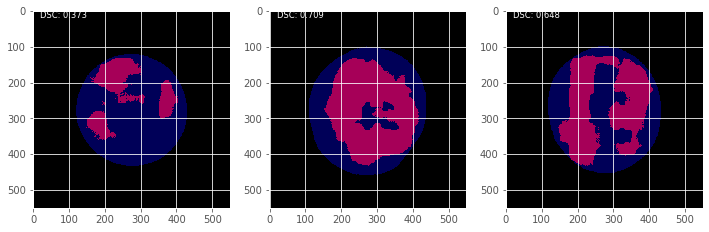

Evaluate fold  2


KeyboardInterrupt: ignored

In [56]:
results_OD, metrics_OD = k_fold_crossval(X, y_OD, ix, callbacks_OD, 'OD', k=5,
                                         random_state=4, verbose=0, save=1)

In [ ]:
results_OC, metrics_OC = k_fold_crossval(X, y_OC, callbacks_OC, 'OC', k=5, 
                                         random_state=4, verbose=0, save=1)

In [ ]:
input_img = Input((550,550, 1), name='img')

In [ ]:
model_OD = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OD.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

model_OC = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OC.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

In [ ]:
model_OD.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 550, 550, 1) 0                                            
__________________________________________________________________________________________________
lambda_input (Lambda)           (None, 256, 256, 1)  0           img[0][0]                        
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 256, 256, 64) 640         lambda_input[0][0]               
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 256, 256, 64) 256         conv2d_71[0][0]                  
____________________________________________________________________________________________

In [ ]:
results_OD = model_OD.fit(X_train_OD, y_train_OD, batch_size=20, epochs=100, callbacks=callbacks_OD,\
                    validation_data=(X_test_OD, y_test_OD))

Epoch 1/100
19/19 [==============================] - 85s 1s/step - loss: 0.5043 - accuracy: 0.7048 - fscore: 0.6498 - val_loss: 11.0731 - val_accuracy: 0.1455 - val_fscore: 0.2380
Epoch 2/100
19/19 [==============================] - 20s 1s/step - loss: 0.2605 - accuracy: 0.8166 - fscore: 0.7746 - val_loss: 8.3471 - val_accuracy: 0.1553 - val_fscore: 0.2399
Epoch 3/100
19/19 [==============================] - 20s 1s/step - loss: 0.2238 - accuracy: 0.8104 - fscore: 0.7653 - val_loss: 3.2058 - val_accuracy: 0.2923 - val_fscore: 0.2701
Epoch 4/100
19/19 [==============================] - 20s 1s/step - loss: 0.1841 - accuracy: 0.8285 - fscore: 0.8105 - val_loss: 3.2839 - val_accuracy: 0.2928 - val_fscore: 0.2707
Epoch 5/100
19/19 [==============================] - 20s 1s/step - loss: 0.1812 - accuracy: 0.8279 - fscore: 0.7933 - val_loss: 2.5999 - val_accuracy: 0.3859 - val_fscore: 0.2958
Epoch 6/100
19/19 [==============================] - 20s 1s/step - loss: 0.1565 - accuracy: 0.8277 - fsc

In [ ]:
results_OC = model_OC.fit(X_train_OC, y_train_OC, batch_size=32, epochs=100, callbacks=callbacks_OC,\
                    validation_data=(X_test_OC, y_test_OC))

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.8253 - fscore: 0.4865

In [ ]:
metrics_OD.describe()

In [ ]:
metrics_OC.describe()

In [ ]:
histo(results_OD)

In [ ]:
histo(results_OC)

In [ ]:
plt.figure(figsize=(14, 7))
plt.title("Learning curve")

plt.subplot(231), 
plt.plot(results_OD.history["accuracy"], label="accuracy")
plt.plot(results_OD.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(results_OD.history["val_accuracy"]), np.max(results_OD.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(232), 
plt.plot(results_OD.history["f1_m"], label="fscore")
plt.plot(results_OD.history["val_f1_m"], label="val_fscore")
plt.plot( np.argmin(results_OD.history["val_f1_m"]), np.max(results_OD.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Fscore")
plt.legend()
plt.subplot(233),
plt.plot(results_OD.history["loss"], label="loss")
plt.plot(results_OD.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_OD.history["val_loss"]), np.min(results_OD.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.subplot(223), 
plt.plot(results_OC.history["f1_m"], label="f1_m")
plt.plot(results_OC.history["val_f1_m"], label="val_f1_m")
plt.plot( np.argmin(results_OC.history["val_f1_m"]), np.min(results_OC.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Fscore")
plt.legend()
plt.title("Learning curve")
plt.subplot(224),
plt.plot(results_OC.history["loss"], label="loss")
plt.plot(results_OC.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_OC.history["val_loss"]), np.min(results_OC.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()


In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

# Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
model_OD.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD.evaluate(X_test_OD, y_test_OD, verbose=1)
model_OC.evaluate(X_test_OC, y_test_OC, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train_OD = model_OD.predict(X_train_OD, verbose=1)
preds_val_OD = model_OD.predict(X_test_OD, verbose=1)
preds_train_OC = model_OC.predict(X_train_OC, verbose=1)
preds_val_OC = model_OC.predict(X_test_OC, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t_OD = (preds_train_OD > 0.5).astype(np.uint8)
preds_val_t_OD = (preds_val_OD > 0.5).astype(np.uint8)
preds_train_t_OC = (preds_train_OC > 0.5).astype(np.uint8)
preds_val_t_OC = (preds_val_OC > 0.5).astype(np.uint8)

In [ ]:
import scipy.ndimage
import cv2
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

    resample = cv2.resize(binary_preds[ix].squeeze(), (550, 550), interpolation = cv2.INTER_CUBIC)
    ax[4].imshow(resample)
    ax[4].set_title('resampled')
    print(resample.shape)

# Plot image

In [ ]:
# Check if training data looks all right
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=30)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=30)

In [ ]:
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=1)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=1)

# Saving model

In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')